In [3]:
import os
os.chdir('../')
import sys


import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tsnet.models.tsnet_freq import TSNetFreq, Configs

## Dataset and Dataloader

In [4]:
# Use ETTh1 dataset for demonstration

ett_h1 = pd.read_csv('data/ETTh1.csv')
ett_h1['date'] = pd.to_datetime(ett_h1['date'])

# Split the dataset into train, validation, and test sets in 70/20/10 ratio
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

num_total = len(ett_h1)  # Total number of time points
train_end = int(num_total * train_ratio)         # 0.7 N
val_end = train_end + int(num_total * val_ratio) # 0.9 N

ett_train_df = ett_h1.iloc[:train_end]
ett_val_df = ett_h1.iloc[train_end:val_end].reset_index(drop=True)
ett_test_df = ett_h1.iloc[val_end:].reset_index(drop=True,)

In [5]:
class ETTDataset(Dataset):
    def __init__(self, data, seq_len, label_len, pred_len, 
                 selected_cols=None, time_col='date', scale=True):
        """
        Parameters:
        - data: path to CSV file or pandas DataFrame
        - seq_len: input sequence length
        - label_len: length of known labels passed into decoder
        - pred_len: prediction length
        - selected_cols: subset of features to use (list of column names)
        - time_col: name of timestamp column
        - scale: apply z-score normalization to features
        """
        if isinstance(data, str):
            df = pd.read_csv(data)
        else:
            df = data.copy()

        self.seq_len = seq_len
        self.label_len = label_len
        self.pred_len = pred_len

        # Extract and remove timestamps
        self.timestamps = pd.to_datetime(df[time_col])
        df.drop(columns=[time_col], inplace=True)

        # Filter feature columns
        if selected_cols:
            df = df[selected_cols]
        self.feature_cols = df.columns

        # Normalize features
        self.raw_data = df.values
        if scale:
            self.mean = self.raw_data.mean(axis=0)
            self.std = self.raw_data.std(axis=0) + 1e-5
            self.data = (self.raw_data - self.mean) / self.std
        else:
            self.data = self.raw_data

        # Build temporal features (minute, hour, weekday, day, month)
        self.time_features = np.stack([
            self.timestamps.dt.minute / 59.0 - 0.5,
            self.timestamps.dt.hour / 23.0 - 0.5,
            self.timestamps.dt.weekday / 6.0 - 0.5,
            (self.timestamps.dt.day - 1) / 30.0 - 0.5,
            (self.timestamps.dt.month - 1) / 11.0 - 0.5,
        ], axis=-1)

    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1

    def __getitem__(self, idx):
        s = idx
        e = s + self.seq_len
        r = e - self.label_len
        t = e + self.pred_len

        seq_seen = self.data[s:e]
        seq_pred = self.data[e:t]
        seen_mark = self.time_features[s:e]
        pred_mark = self.time_features[e:t]

        return (
            torch.tensor(seq_seen, dtype=torch.float),       # encoder input
            torch.tensor(seen_mark, dtype=torch.float),      # encoder time mark
            torch.tensor(seq_pred, dtype=torch.float),       # decoder target
            torch.tensor(pred_mark, dtype=torch.float),      # decoder time mark
            {
                "columns": list(self.feature_cols),
                "seen_start": str(self.timestamps[s]),
                "seen_end": str(self.timestamps[e - 1]),
                "pred_start": str(self.timestamps[r]),
                "pred_end": str(self.timestamps[t - 1])
            }
        )

In [6]:
ett_train_dataset = ETTDataset(ett_train_df, 
                                seq_len=96, 
                                label_len=48, 
                                pred_len=24, 
                                selected_cols=['HUFL'],
                                time_col='date')

ett_val_dataset = ETTDataset(ett_val_df,
                                seq_len=96, 
                                label_len=48, 
                                pred_len=24, 
                                selected_cols=['HUFL'],
                                time_col='date')

ett_test_dataset = ETTDataset(ett_test_df,
                                seq_len=96, 
                                label_len=48, 
                                pred_len=24, 
                                selected_cols=['HUFL'],
                                time_col='date')

train_loader = DataLoader(ett_train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(ett_val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(ett_test_dataset, batch_size=256, shuffle=False)

## Training Pipeline

In [7]:
configs = Configs(
    seq_len = 96,
    label_len = 48,
    pred_len = 24,
    in_channels = 1,
    out_channels = 1,
    d_model = 128,
    enc_layers = 2,
    dec_layers = 2,
    batch_size = 256,
    channel_independence = True,
    task = 'forecasting',
)

LR = 1e-3
EPOCHS = 50

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TSNetFreq(configs)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), LR)
criterion = nn.MSELoss()

In [9]:
# x, xm, y, ym, info = next(iter(test_loader))
# print("Input shape:", x.shape)
# print("Input time mark shape:", xm.shape)   

In [8]:
def train_tsnet(model, train_loader, val_loader, criterion, optimizer, device, configs, checkpoint_dir):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    os.makedirs(checkpoint_dir, exist_ok=True)
    best_ckpt_path = os.path.join(checkpoint_dir, 'tsnet_best.pt')

    for epoch in tqdm(range(EPOCHS), desc="Training Epochs"):
        model.train()
        total_train_loss = 0.0

        for x, x_mark, y, y_mark, _ in train_loader:
            x, x_mark, y = x.to(device), x_mark.to(device), y.to(device)

            optimizer.zero_grad()
            output = model(x, x_mark)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for x, x_mark, y, y_mark, _ in val_loader:
                x, x_mark, y = x.to(device), x_mark.to(device), y.to(device)

                output = model(x, x_mark)
                loss = criterion(output, y)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_ckpt_path)
            print(f"Best model saved to {best_ckpt_path}")

        # Save checkpoint per epoch
        epoch_ckpt_path = os.path.join(checkpoint_dir, f'tsnet_epoch{epoch+1}.pt')
        torch.save(model.state_dict(), epoch_ckpt_path)

    return train_losses, val_losses

In [9]:
train_losses, val_losses = train_tsnet(
    model, train_loader, val_loader,
    criterion, optimizer, device, configs, checkpoint_dir="./checkpoint_dir"
)

Training Epochs:   2%|▏         | 1/50 [00:42<34:23, 42.10s/it]

Epoch 1 | Train Loss: 1.8197 | Val Loss: 0.7286
Best model saved to ./checkpoint_dir/tsnet_best.pt


Training Epochs:   4%|▍         | 2/50 [01:24<33:42, 42.13s/it]

Epoch 2 | Train Loss: 0.7383 | Val Loss: 0.7832


Training Epochs:   6%|▌         | 3/50 [02:05<32:40, 41.72s/it]

Epoch 3 | Train Loss: 0.6615 | Val Loss: 0.6994
Best model saved to ./checkpoint_dir/tsnet_best.pt


Training Epochs:   8%|▊         | 4/50 [02:46<31:49, 41.51s/it]

Epoch 4 | Train Loss: 0.5938 | Val Loss: 0.5850
Best model saved to ./checkpoint_dir/tsnet_best.pt


Training Epochs:  10%|█         | 5/50 [03:28<31:07, 41.50s/it]

Epoch 5 | Train Loss: 0.6707 | Val Loss: 0.7982


Training Epochs:  12%|█▏        | 6/50 [04:09<30:25, 41.48s/it]

Epoch 6 | Train Loss: 0.6255 | Val Loss: 0.7319


Training Epochs:  14%|█▍        | 7/50 [04:51<29:44, 41.50s/it]

Epoch 7 | Train Loss: 0.5470 | Val Loss: 0.6186


Training Epochs:  16%|█▌        | 8/50 [05:33<29:14, 41.77s/it]

Epoch 8 | Train Loss: 0.5067 | Val Loss: 0.6050


Training Epochs:  18%|█▊        | 9/50 [06:15<28:41, 41.98s/it]

Epoch 9 | Train Loss: 0.4793 | Val Loss: 0.5893


Training Epochs:  20%|██        | 10/50 [06:58<28:01, 42.04s/it]

Epoch 10 | Train Loss: 0.4548 | Val Loss: 0.5180
Best model saved to ./checkpoint_dir/tsnet_best.pt


Training Epochs:  22%|██▏       | 11/50 [07:40<27:21, 42.08s/it]

Epoch 11 | Train Loss: 0.4341 | Val Loss: 0.5052
Best model saved to ./checkpoint_dir/tsnet_best.pt


Training Epochs:  24%|██▍       | 12/50 [08:22<26:41, 42.14s/it]

Epoch 12 | Train Loss: 0.4248 | Val Loss: 0.4858
Best model saved to ./checkpoint_dir/tsnet_best.pt


Training Epochs:  26%|██▌       | 13/50 [09:03<25:50, 41.91s/it]

Epoch 13 | Train Loss: 0.4226 | Val Loss: 0.4872


Training Epochs:  28%|██▊       | 14/50 [09:46<25:11, 41.99s/it]

Epoch 14 | Train Loss: 0.4162 | Val Loss: 0.5366


Training Epochs:  30%|███       | 15/50 [10:27<24:25, 41.88s/it]

Epoch 15 | Train Loss: 0.4535 | Val Loss: 0.5796


Training Epochs:  32%|███▏      | 16/50 [11:09<23:38, 41.72s/it]

Epoch 16 | Train Loss: 0.4326 | Val Loss: 0.5144


Training Epochs:  34%|███▍      | 17/50 [11:50<22:55, 41.69s/it]

Epoch 17 | Train Loss: 0.4159 | Val Loss: 0.4846
Best model saved to ./checkpoint_dir/tsnet_best.pt


Training Epochs:  36%|███▌      | 18/50 [12:32<22:15, 41.74s/it]

Epoch 18 | Train Loss: 0.4105 | Val Loss: 0.4880


Training Epochs:  38%|███▊      | 19/50 [13:14<21:34, 41.76s/it]

Epoch 19 | Train Loss: 0.4167 | Val Loss: 0.5230


Training Epochs:  40%|████      | 20/50 [13:56<20:58, 41.95s/it]

Epoch 20 | Train Loss: 0.4096 | Val Loss: 0.4784
Best model saved to ./checkpoint_dir/tsnet_best.pt


Training Epochs:  42%|████▏     | 21/50 [14:39<20:19, 42.07s/it]

Epoch 21 | Train Loss: 0.3961 | Val Loss: 0.4708
Best model saved to ./checkpoint_dir/tsnet_best.pt


Training Epochs:  44%|████▍     | 22/50 [15:21<19:41, 42.18s/it]

Epoch 22 | Train Loss: 0.3899 | Val Loss: 0.4692
Best model saved to ./checkpoint_dir/tsnet_best.pt


Training Epochs:  46%|████▌     | 23/50 [16:04<19:05, 42.42s/it]

Epoch 23 | Train Loss: 0.3935 | Val Loss: 0.4690
Best model saved to ./checkpoint_dir/tsnet_best.pt


Training Epochs:  48%|████▊     | 24/50 [16:47<18:24, 42.49s/it]

Epoch 24 | Train Loss: 0.3869 | Val Loss: 0.4618
Best model saved to ./checkpoint_dir/tsnet_best.pt


Training Epochs:  50%|█████     | 25/50 [17:29<17:41, 42.46s/it]

Epoch 25 | Train Loss: 0.3876 | Val Loss: 0.4856


Training Epochs:  52%|█████▏    | 26/50 [18:12<16:59, 42.48s/it]

Epoch 26 | Train Loss: 0.3914 | Val Loss: 0.4473
Best model saved to ./checkpoint_dir/tsnet_best.pt


Training Epochs:  54%|█████▍    | 27/50 [18:54<16:15, 42.42s/it]

Epoch 27 | Train Loss: 0.3809 | Val Loss: 0.4482


Training Epochs:  56%|█████▌    | 28/50 [19:37<15:34, 42.49s/it]

Epoch 28 | Train Loss: 0.3769 | Val Loss: 0.4706


Training Epochs:  58%|█████▊    | 29/50 [20:19<14:52, 42.51s/it]

Epoch 29 | Train Loss: 0.3708 | Val Loss: 0.4612


Training Epochs:  60%|██████    | 30/50 [21:02<14:09, 42.49s/it]

Epoch 30 | Train Loss: 0.3710 | Val Loss: 0.4575


Training Epochs:  62%|██████▏   | 31/50 [21:44<13:27, 42.49s/it]

Epoch 31 | Train Loss: 0.3802 | Val Loss: 0.4765


Training Epochs:  64%|██████▍   | 32/50 [22:27<12:45, 42.53s/it]

Epoch 32 | Train Loss: 0.3722 | Val Loss: 0.4579


Training Epochs:  66%|██████▌   | 33/50 [23:09<12:04, 42.63s/it]

Epoch 33 | Train Loss: 0.3675 | Val Loss: 0.4553


Training Epochs:  68%|██████▊   | 34/50 [23:53<11:24, 42.79s/it]

Epoch 34 | Train Loss: 0.3647 | Val Loss: 0.4478


Training Epochs:  70%|███████   | 35/50 [24:34<10:34, 42.33s/it]

Epoch 35 | Train Loss: 0.4174 | Val Loss: 0.5709


Training Epochs:  70%|███████   | 35/50 [25:05<10:45, 43.03s/it]


KeyboardInterrupt: 

## Model Evaluation

In [10]:
model = TSNetFreq(configs)
model.load_state_dict(torch.load("./checkpoint_dir/tsnet_best.pt"))
model.eval()

TSNetFreq(
  (enc_embedding): DataEmbedding(
    (value_embedding): ValueEmbedding(
      (proj): Linear(in_features=1, out_features=128, bias=True)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TemporalEmbedding(
      (minute_embed): FixedEmbedding()
      (hour_embed): FixedEmbedding()
      (weekday_embed): FixedEmbedding()
      (day_embed): FixedEmbedding()
      (month_embed): FixedEmbedding()
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): ValueEmbedding(
      (proj): Linear(in_features=1, out_features=128, bias=True)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TemporalEmbedding(
      (minute_embed): FixedEmbedding()
      (hour_embed): FixedEmbedding()
      (weekday_embed): FixedEmbedding()
      (day_embed): FixedEmbedding()
      (month_embed): FixedEmbedding()
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TSNetEncoder

In [11]:
x, x_mark, y, y_mark, meta = next(iter(test_loader))
with torch.no_grad():
    pred = model(x, x_mark)
pred = pred.squeeze(0).cpu().numpy()  # [pred_len, C]
gt = torch.cat((x, y), dim=1).cpu().numpy()  # Concatenate x and y along the second dimension

In [12]:
pred.shape, y.shape

((256, 24, 1), torch.Size([256, 24, 1]))

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Flatten the arrays to compute metrics across all elements
pred_flat = pred.flatten()
y_flat = y.numpy().flatten()

# Compute MSE and MAE
mse = mean_squared_error(pred_flat, y_flat)
mae = mean_absolute_error(pred_flat, y_flat)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Squared Error (MSE): 0.4221
Mean Absolute Error (MAE): 0.4984


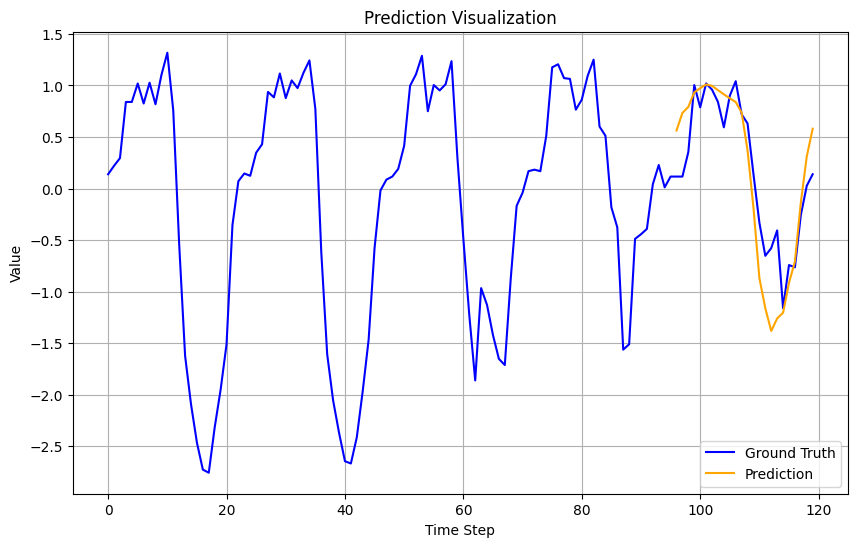

In [27]:
# Generate a random index
random_index = random.randint(0, x.shape[0] - 1)

# Select the sequence
pred_sequence = pred[random_index, :, 0]
gt_sequence = gt[random_index, :, 0]

# Define the ranges for ground truth and prediction
gt_range = range(0, configs.seq_len + configs.pred_len)
pred_range = range(configs.seq_len, configs.seq_len + configs.pred_len)

# Plot the sequences
plt.figure(figsize=(10, 6))
plt.plot(gt_range, gt_sequence, label="Ground Truth", color="blue")
plt.plot(pred_range, pred_sequence, label="Prediction", color="orange")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Prediction Visualization")
plt.legend()
plt.grid()
plt.show()